## Imports and setup
TensorFlow 2.4 or higher

In [1]:
# !pip install -U tensorflow-addons

In [2]:
# !pip install tensorflow

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Apr  4 12:00:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 30%   45C    P5    45W / 350W |    619MiB / 24576MiB |     33%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 134.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-04-04 12:00:27.583753: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-04 12:00:27.604685: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-04 12:00:27.723158: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-04 12:00:27.725260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 12:00:28.487056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [6]:
import numpy as np
from ast import literal_eval
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.patches as patches_plt
%matplotlib inline
import pandas as pd
import cv2
from tqdm import tqdm
import os
import scipy.io
import shutil

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

/home/felipe/anaconda3/envs/graffiti/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Prepare the dataset ToyExample
Caltech 101 Dataset

In [7]:
image_size = 224  # resize input images to this size

In [8]:
# Path to images and annotations
path_images = "datasets/caltech-101/101_ObjectCategories/airplanes/"
path_annot = "datasets/caltech-101/Annotations/Airplanes_Side_2/"

path_to_downloaded_file = keras.utils.get_file(
    fname="caltech_101_zipped",
    origin="https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip",
    extract=True,
    archive_format="zip",  # downloaded file format
    cache_dir="./",  # cache and extract in current directory
)

In [9]:
# Extracting tar files found inside main zip file
shutil.unpack_archive("datasets/caltech-101/101_ObjectCategories.tar.gz", "datasets/caltech-101/")
shutil.unpack_archive("datasets/caltech-101/Annotations.tar", "datasets/caltech-101/")

# list of paths to images and annotations
image_paths = [
    f for f in os.listdir(path_images) if os.path.isfile(os.path.join(path_images, f))
]
annot_paths = [
    f for f in os.listdir(path_annot) if os.path.isfile(os.path.join(path_annot, f))
]

image_paths.sort()
annot_paths.sort()

In [10]:
images, targets = [], []
for i in range(0, len(annot_paths)):
    # Access bounding box coordinates
    annot = scipy.io.loadmat(path_annot + annot_paths[i])["box_coord"][0]

    top_left_x, top_left_y = annot[2], annot[0]
    bottom_right_x, bottom_right_y = annot[3], annot[1]

    image = keras.utils.load_img(
        path_images + image_paths[i],
    )
    (w, h) = image.size[:2]
    print(w,h)

    # resize train set images
    if i < int(len(annot_paths) * 0.8):
        # resize image if it is for training dataset
        image = image.resize((image_size, image_size))

    # convert image to array and append to list
    images.append(keras.utils.img_to_array(image))

    # apply relative scaling to bounding boxes as per given image and append to list
    targets.append(
        (
            float(top_left_x) / w,
            float(top_left_y) / h,
            float(bottom_right_x) / w,
            float(bottom_right_y) / h,
        )
    )

398 164
401 184
393 165
393 170
395 176
393 147
391 148
395 149
392 161
397 137
399 162
397 154
392 176
398 152
411 199
392 171
399 174
398 180
394 175
392 192
391 159
394 155
392 145
393 131
397 170
394 155
398 152
394 141
398 144
393 187
402 236
392 147
392 159
392 145
390 161
392 194
393 171
392 113
392 177
393 182
392 166
394 183
395 162
394 164
396 195
397 180
392 190
393 163
399 217
391 155
392 205
392 184
392 175
412 210
393 143
405 140
392 174
395 176
392 210
399 163
392 152
392 165
393 160
392 168
393 154
398 147
393 180
392 173
392 177
393 190
412 191
396 228
392 139
393 127
418 148
392 176
395 158
392 192
394 159
392 165
394 157
393 178
393 188
406 182
394 190
394 142
393 191
416 192
393 180
395 195
393 171
402 191
394 152
392 138
395 172
392 182
394 196
394 206
393 196
393 171
397 210
392 133
395 133
393 212
394 193
402 180
394 180
392 170
394 159
395 176
400 144
395 176
394 152
395 191
393 178
394 170
398 169
392 165
392 101
403 165
401 187
414 176
406 150
402 143
406 155


In [12]:
# annot_file

In [13]:
# Convert the list to numpy array, split to train and test dataset
(x_train), (y_train) = (
    np.asarray(images[: int(len(images) * 0.8)]),
    np.asarray(targets[: int(len(targets) * 0.8)]),
)
(x_test), (y_test) = (
    np.asarray(images[int(len(images) * 0.8) :]),
    np.asarray(targets[int(len(targets) * 0.8) :]),
)  

/tmp/ipykernel_561332/4234801415.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.asarray(images[int(len(images) * 0.8) :]),


In [14]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((640, 224, 224, 3), (640, 4), (160,), (160, 4))

In [15]:
y_train

array([[0.12311558, 0.18292683, 0.87688442, 0.83536585],
       [0.14713217, 0.19021739, 0.85286783, 0.83152174],
       [0.11959288, 0.21818182, 0.84223919, 0.81818182],
       ...,
       [0.13647643, 0.17857143, 0.87096774, 0.83928571],
       [0.13283208, 0.17365269, 0.87468672, 0.83832335],
       [0.12531328, 0.18181818, 0.86967419, 0.83116883]])

### Loading 17k-Graffiti dataset

In [16]:
TRAIN_IMGS = 'datasets/17kGraffiti/split/train/graffiti/'
# DataFrame,dictionary of lists, unpickled_data
train_bboxes = pd.read_pickle('datasets/17kGraffiti/train_bboxes.pkl')
train_bboxes["img_path"] = train_bboxes["FileName"].apply(lambda x: f"{TRAIN_IMGS}{x}.jpg")
train_bboxes = train_bboxes.explode('bbox').copy()
train_bboxes.reset_index(inplace=True)

In [17]:
train_bboxes

index                  FileName  bbox_count                  bbox  \
0          0  10005452375_1fc378fb7f_c           1   [103, 93, 572, 436]   
1          1  10005549113_1057d20b58_c           1   [106, 30, 659, 533]   
2          2  10007929605_a3e9d26cd7_c           1    [5, 286, 781, 645]   
3          3  10008858965_1fe2600f5e_c           1    [34, 13, 770, 584]   
4          4  10008863645_708e989a49_c           1     [7, 84, 781, 511]   
...      ...                       ...         ...                   ...   
13814   6948  16064943625_48c18d21d8_c           6  [390, 143, 514, 286]   
13815   6948  16064943625_48c18d21d8_c           6  [553, 158, 648, 291]   
13816   6948  16064943625_48c18d21d8_c           6  [678, 183, 733, 269]   
13817   6948  16064943625_48c18d21d8_c           6  [465, 458, 731, 586]   
13818   6948  16064943625_48c18d21d8_c           6   [74, 478, 260, 568]   

                                                img_path  
0      datasets/17kGraffiti/split/train/graffiti/1000...  
1      datasets/17kGraffiti/split/train/graffiti/1000...  
2      datasets/17kGraffiti/split/train/graffiti/1000...  
3      datasets/17kGraffiti/split/train/graffiti/1000...  
4      datasets/17kGraffiti/split/train/graffiti/1000...  
...                                                  ...  
13814  datasets/17kGraffiti/split/train/graffiti/1606...  
13815  datasets/17kGraffiti/split/train/graffiti/1606...  
13816  datasets/17kGraffiti/split/train/graffiti/1606...  
13817  datasets/17kGraffiti/split/train/graffiti/1606...  
13818  datasets/17kGraffiti/split/train/graffiti/1606...  

[13819 rows x 5 columns]

In [18]:
TEST_IMGS = 'datasets/17kGraffiti/split/test/graffiti/'
test_bboxes = pd.read_pickle('datasets/17kGraffiti/test_bboxes.pkl')
test_bboxes = test_bboxes.astype(object)
test_bboxes["img_path"] = test_bboxes["FileName"].apply(lambda x: f"{TEST_IMGS}{x}.jpg")
test_bboxes = test_bboxes.explode('bbox').copy()
test_bboxes.reset_index(inplace=True)

In [19]:
test_bboxes

index                  FileName bbox_count                  bbox  \
0         0  10005509946_302a7e4b81_c          2    [7, 108, 153, 377]   
1         0  10005509946_302a7e4b81_c          2   [186, 62, 716, 387]   
2         1  10008085844_aa0cb2ec39_c          1    [18, 39, 773, 241]   
3         2  10034314145_18c252992b_c          3     [3, 93, 144, 303]   
4         2  10034314145_18c252992b_c          3    [85, 58, 259, 288]   
...     ...                       ...        ...                   ...   
3007   1735  29566606407_70d4dac576_c          5   [63, 170, 344, 290]   
3008   1735  29566606407_70d4dac576_c          5  [354, 174, 509, 277]   
3009   1735  29566606407_70d4dac576_c          5  [505, 202, 606, 273]   
3010   1735  29566606407_70d4dac576_c          5  [600, 208, 677, 279]   
3011   1735  29566606407_70d4dac576_c          5  [676, 218, 786, 270]   

                                               img_path  
0     datasets/17kGraffiti/split/test/graffiti/10005...  
1     datasets/17kGraffiti/split/test/graffiti/10005...  
2     datasets/17kGraffiti/split/test/graffiti/10008...  
3     datasets/17kGraffiti/split/test/graffiti/10034...  
4     datasets/17kGraffiti/split/test/graffiti/10034...  
...                                                 ...  
3007  datasets/17kGraffiti/split/test/graffiti/29566...  
3008  datasets/17kGraffiti/split/test/graffiti/29566...  
3009  datasets/17kGraffiti/split/test/graffiti/29566...  
3010  datasets/17kGraffiti/split/test/graffiti/29566...  
3011  datasets/17kGraffiti/split/test/graffiti/29566...  

[3012 rows x 5 columns]

In [22]:
images_train, targets_train = [], []
# loop over the annotations and images, preprocess them and store in lists
for index, row in tqdm(train_bboxes[train_bboxes["bbox_count"]==1].iterrows()):
    
    image = keras.utils.load_img(row["img_path"], grayscale=False, color_mode='rgb')
    #image = keras.utils.img_to_array(image)
    (w, h) = image.size[:2]

    image = image.resize((image_size, image_size))
#     image = cv2.resize(image, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
    # convert image to array and append to list
    images_train.append(keras.utils.img_to_array(image))
    
    # Access bounding box coordinates
    top_left_x, top_left_y = row["bbox"][0], row["bbox"][1]
    bottom_right_x, bottom_right_y = row["bbox"][2], row["bbox"][3]

    targets_train.append(
            (
                float(top_left_x) / w,
                float(top_left_y) / h,
                float(bottom_right_x) / w,
                float(bottom_right_y) / h,
            )
    )
#     sub_targets = []
#     for annot in row["bbox"]:

#         top_left_x, top_left_y = annot[2], annot[0]
        

#         # apply relative scaling to bounding boxes as per given image and append to list
#         sub_targets.append(
#             (
#                 float(top_left_x) / w,
#                 float(top_left_y) / h,
#                 float(bottom_right_x) / w,
#                 float(bottom_right_y) / h,
#             )
#         )

#     sub_targets = np.asarray(sub_targets).astype('float32')
        
#     targets_train.append(sub_targets)


4115it [00:25, 162.32it/s]


In [44]:
images_test, targets_test = [], []
# loop over the annotations and images, preprocess them and store in lists
#for index, row in tqdm(test_bboxes[test_bboxes["bbox_count"]==1].iterrows()):
for index, row in tqdm(test_bboxes.iterrows()):
    
    image = keras.utils.load_img(row["img_path"], grayscale=False, color_mode='rgb')
    #image = keras.utils.img_to_array(image)
    (w, h) = image.size[:2]

    image = image.resize((image_size, image_size))
#     image = cv2.resize(image, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
    # convert image to array and append to list
    images_test.append(keras.utils.img_to_array(image))
    
    # Access bounding box coordinates
    top_left_x, top_left_y = row["bbox"][0], row["bbox"][1]
    bottom_right_x, bottom_right_y = row["bbox"][2], row["bbox"][3]

    targets_test.append(
            (
                float(top_left_x) / w,
                float(top_left_y) / h,
                float(bottom_right_x) / w,
                float(bottom_right_y) / h,
            )
    )
#     sub_targets = []
#     for annot in row["bbox"]:

#         top_left_x, top_left_y = annot[2], annot[0]
        

#         # apply relative scaling to bounding boxes as per given image and append to list
#         sub_targets.append(
#             (
#                 float(top_left_x) / w,
#                 float(top_left_y) / h,
#                 float(bottom_right_x) / w,
#                 float(bottom_right_y) / h,
#             )
#         )

#     sub_targets = np.asarray(sub_targets).astype('float32')
        
#     targets_train.append(sub_targets)


3012it [00:14, 204.26it/s]


In [46]:
# # Convert the list to numpy array, split to train and test dataset
x_train, y_train = np.asarray(images_train), np.asarray(targets_train)
                        
x_test, y_test = np.asarray(images_test), np.asarray(targets_test)

In [47]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4115, 224, 224, 3), (4115, 4), (3012, 224, 224, 3), (3012, 4))

In [26]:
y_train, y_test

(array([[0.12875   , 0.155     , 0.715     , 0.72666667],
        [0.13266583, 0.04991681, 0.82478098, 0.88685524],
        [0.00625782, 0.40857143, 0.97747184, 0.92142857],
        ...,
        [0.06132666, 0.18574109, 0.95744681, 0.75422139],
        [0.13866667, 0.23      , 0.70666667, 0.756     ],
        [0.04      , 0.205     , 0.97      , 0.72833333]]),
 array([[0.02252816, 0.14391144, 0.96745932, 0.88929889],
        [0.0475    , 0.23791103, 0.9175    , 0.88974855],
        [0.0475    , 0.18469657, 0.9175    , 0.83113456],
        ...,
        [0.0575    , 0.04029304, 0.945     , 0.88644689],
        [0.065     , 0.15283843, 0.9225    , 0.79912664],
        [0.1126408 , 0.15413534, 0.9612015 , 0.85714286]]))

## Implement multilayer-perceptron (MLP)

In [27]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Implement the patch creation layer

In [28]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    #     Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # return patches
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

## Display patches for an input image

Image size: 224 X 224
Patch size: 32 X 32
49 patches per image 
3072 elements per patch


2023-04-04 13:34:36.822921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-04 13:34:36.823577: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


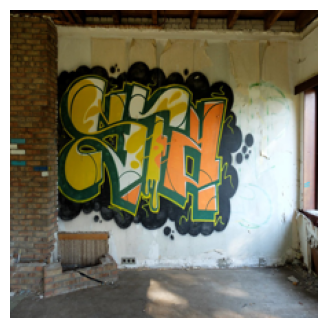

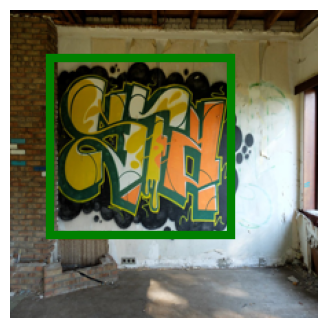

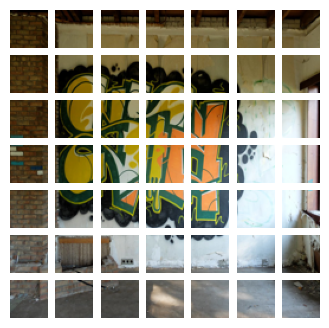

In [29]:
patch_size = 32  # Size of the patches to be extracted from the input images

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.axis("off")

patches = Patches(patch_size)(tf.convert_to_tensor([x_train[0]]))
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"{patches.shape[1]} patches per image \n{patches.shape[-1]} elements per patch")

# Create figure and axes
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(x_train[0].astype("uint8"))
W_, H_ = x_train[0].shape[:2]

xmin, ymin = y_train[0][0]*W_, y_train[0][1]*H_
w_, h_ = (y_train[0][2] - y_train[0][0])*W_, (y_train[0][3] - y_train[0][1])*H_

rect = patches_plt.Rectangle((xmin, ymin), w_, h_, linewidth=6, edgecolor='g', facecolor='none')
ax.add_patch(rect)
plt.axis("off")
plt.show()

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Implement the patch encoding layer

In [30]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    # Override function to avoid error while saving model
    def get_config(self):
        config = super().get_config().copy()
        config.update(
            {
                "input_shape": input_shape,
                "patch_size": patch_size,
                "num_patches": num_patches,
                "projection_dim": projection_dim,
                "num_heads": num_heads,
                "transformer_units": transformer_units,
                "transformer_layers": transformer_layers,
                "mlp_head_units": mlp_head_units,
            }
        )
        return config

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Build the ViT model

In [31]:
def create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
):
    inputs = layers.Input(shape=input_shape)
    # Create patches
    patches = Patches(patch_size)(inputs)
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.4)

    bounding_box = layers.Dense(4)(
        features
    )  # Final four neurons that output bounding box

    # return Keras model.
    return keras.Model(inputs=inputs, outputs=bounding_box)

In [32]:
input_shape = (image_size, image_size, 3)  # input image shape
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 5
# Size of the transformer layers
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 4
mlp_head_units = [2048, 1024, 512, 64, 32]  # Size of the dense layers

In [33]:
model = create_vit_object_detector(
    input_shape,
    patch_size,
    num_patches,
    projection_dim,
    num_heads,
    transformer_units,
    transformer_layers,
    mlp_head_units,
)

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 patches_1 (Patches)            (None, None, 3072)   0           ['input_1[0][0]']                
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 49, 64)       199808      ['patches_1[0][0]']              
                                                                                                  
 layer_normalization (LayerNorm  (None, 49, 64)      128         ['patch_encoder[0][0]']      

 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                                  
 add_6 (Add)                    (None, 49, 64)       0           ['multi_head_attention_3[0][0]', 
                                                                  'add_5[0][0]']                  
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 49, 64)      128         ['add_6[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_7 (Dense)                (None, 49, 128)      8320        ['layer_normalization_7[0][0]']  
                                                                                                  
 dropout_6

### Preparing data

In [35]:
# ATH_2_TRAINING_IMGS,
#                            train_bboxes,
#this class is used to construct our graffiti dataset
class GraffitiKerasDataset(keras.utils.Sequence):
    def __init__(self, image_dir, imagedata, 
                                 transforms = None, 
                                 batch_size=128, 
                                 image_resize = 224,
                                 n_channels=3):
        super().__init__()
        self.image_dir = image_dir
        self.imagedata = imagedata
        self.transforms = transforms
        self.image_resize = image_resize
        self.batch_size = batch_size
        self.n_channels = n_channels
        
        self.num_batches = int(np.ceil(len(self.imagedata) / self.batch_size))

    def on_epoch_end(self):
        pass
    
    def __getbbox(self, df):
        
#         df = self.imagedata.loc[idx, :]
        
        images_, bboxes_ = [], []
        #images_ = np.empty((self.batch_size, self.image_resize, self.image_resize , self.n_channels))
        #bboxes_ = np.empty((self.batch_size, 1, 4))
        
        for index, row in tqdm(df.iterrows()):
            try:
                image = keras.utils.load_img(row["img_path"], grayscale=False, color_mode='rgb')
            except:
                raise(f'Error: No image file exist with name {image_name}')
                
            image = keras.utils.img_to_array(image)
            (w, h) = image.shape[:2]

            #image = image.resize((image_size, image_size))
            image = cv2.resize(image, dsize=(image_size, image_size), interpolation=cv2.INTER_CUBIC)
            # convert image to array and append to list
            images_.append(image)

            boxes_resize=[]
            for bb in row["bbox"]:
                xmin,ymin,xmax,ymax= bb
                xmin_corr = (xmin/w)*self.image_resize
                #if xmax > w:
                #    print(xmax_corr)
                xmax_corr = (xmax/w)*self.image_resize
                ymin_corr = (ymin/h)*self.image_resize
                ymax_corr = (ymax/h)*self.image_resize

                boxes_resize.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])

            bboxes_.append(np.array(boxes_resize,dtype='float32'))

        images = np.asarray(images_)
        boxes = np.asarray(bboxes_)
        
        return images, boxes
    
    def __getitem__(self, index):
        
        batches = self.imagedata[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__getbbox(batches)
        print(X.shape)
        print(y.shape)
        print(y)
        return X, y
        

    def __len__(self)->int:
        return self.num_batches

In [ ]:
# train_data = GraffitiKerasDataset(TRAIN_IMGS, train_bboxes[train_bboxes["bbox_count"]==1].copy())

## Run the experiment

In [36]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100

In [37]:
optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

In [38]:
checkpoint_filepath = "logs/"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
)

In [39]:
model.compile(optimizer=optimizer, loss=keras.losses.MeanSquaredError())

In [40]:
history = model.fit(
           x=x_train,
           y=y_train,
#             data_generator,
            batch_size=batch_size,
            epochs=num_epochs,
            validation_split=0.1,
            callbacks=[
                checkpoint_callback,
                keras.callbacks.EarlyStopping(monitor="val_loss", patience=15),
            ],
        )

Epoch 1/100
29/29 [==============================] - 7s 154ms/step - loss: 0.6673 - val_loss: 0.3259
Epoch 2/100
29/29 [==============================] - 4s 139ms/step - loss: 0.2936 - val_loss: 0.2577
Epoch 3/100
29/29 [==============================] - 4s 138ms/step - loss: 0.2285 - val_loss: 0.1991
Epoch 4/100
29/29 [==============================] - 4s 139ms/step - loss: 0.1740 - val_loss: 0.1485
Epoch 5/100
29/29 [==============================] - 4s 137ms/step - loss: 0.1276 - val_loss: 0.1056
Epoch 6/100
29/29 [==============================] - 4s 139ms/step - loss: 0.0900 - val_loss: 0.0713
Epoch 7/100
29/29 [==============================] - 4s 140ms/step - loss: 0.0613 - val_loss: 0.0466
Epoch 8/100
29/29 [==============================] - 4s 138ms/step - loss: 0.0427 - val_loss: 0.0309
Epoch 9/100
29/29 [==============================] - 4s 138ms/step - loss: 0.0316 - val_loss: 0.0220
Epoch 10/100
29/29 [==============================] - 4s 143ms/step - loss: 0.0261 - val_lo

In [41]:
model.save("vit_object_detector.h5", save_format="h5")

## Evaluate the model

In [42]:
import matplotlib.patches as patches

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )

1/1 [==============================] - 0s 12ms/step
mean_iou: 0.3400427380500305


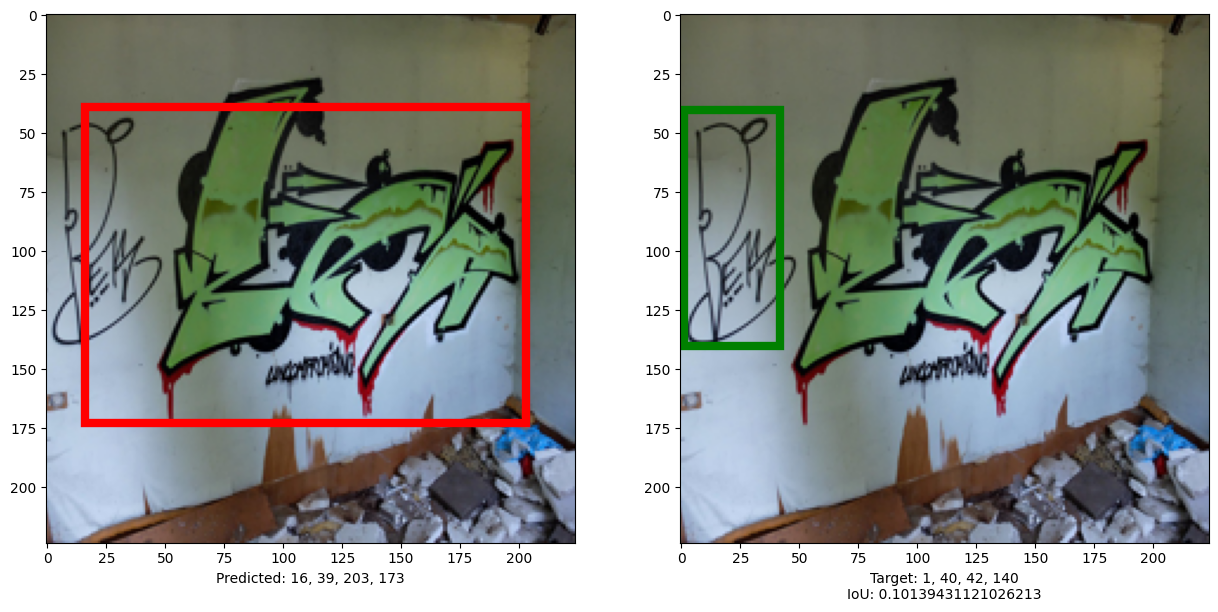

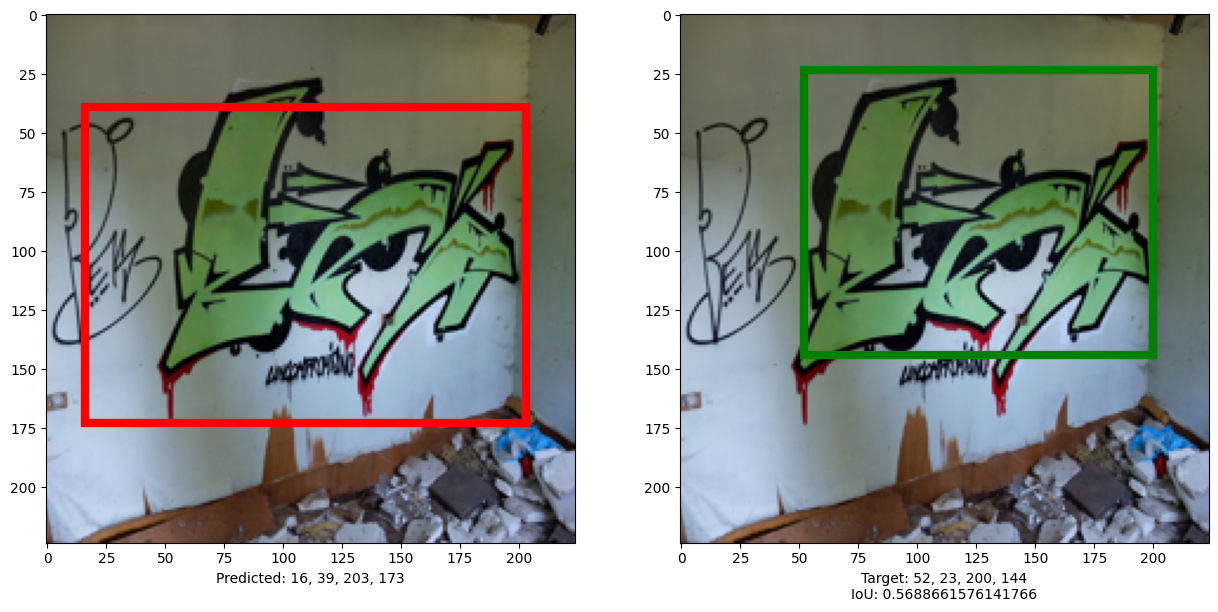

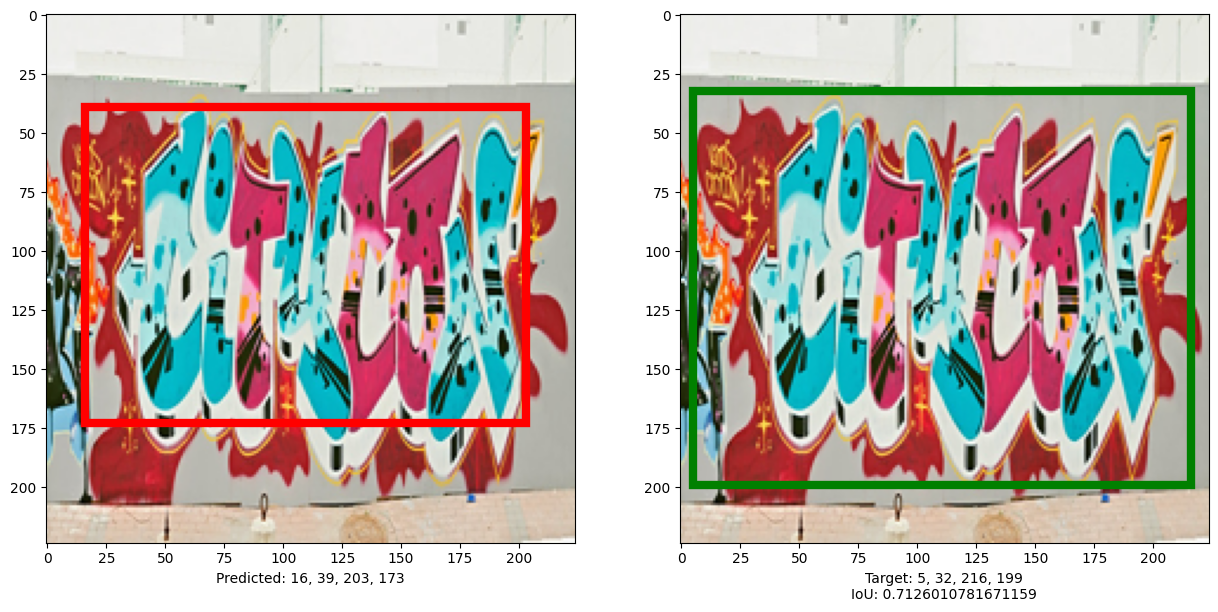

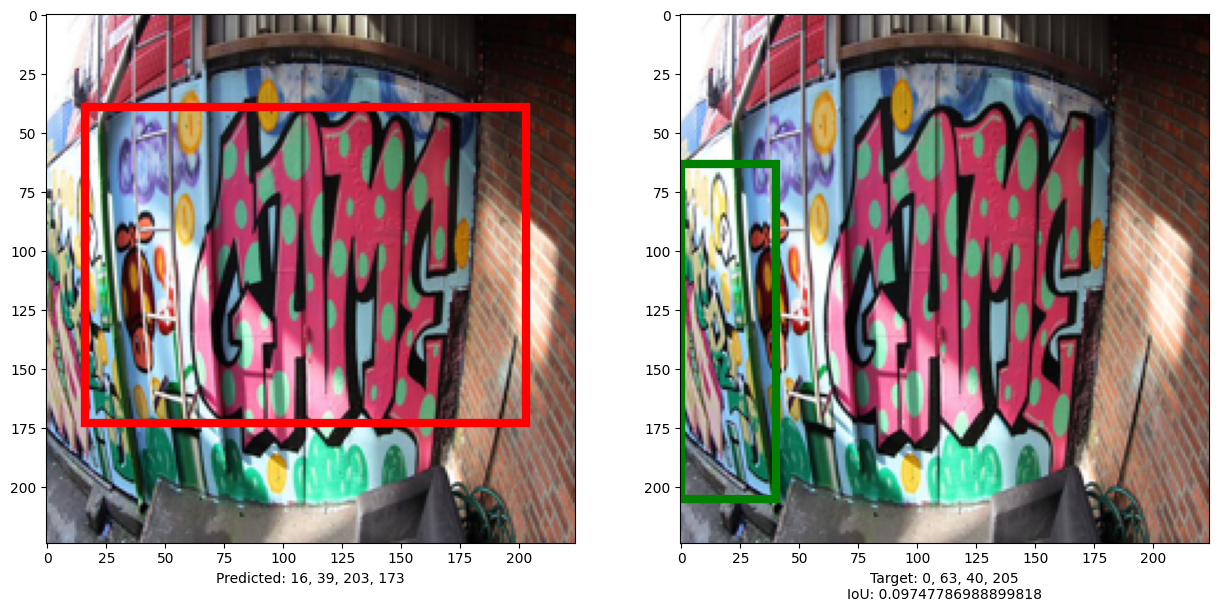

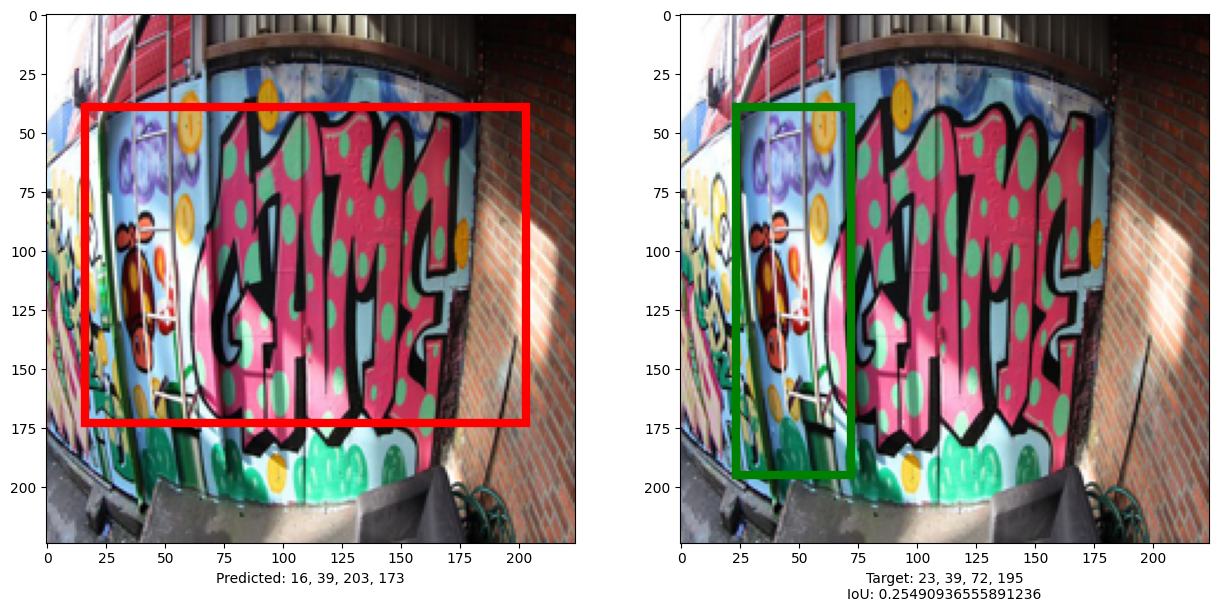

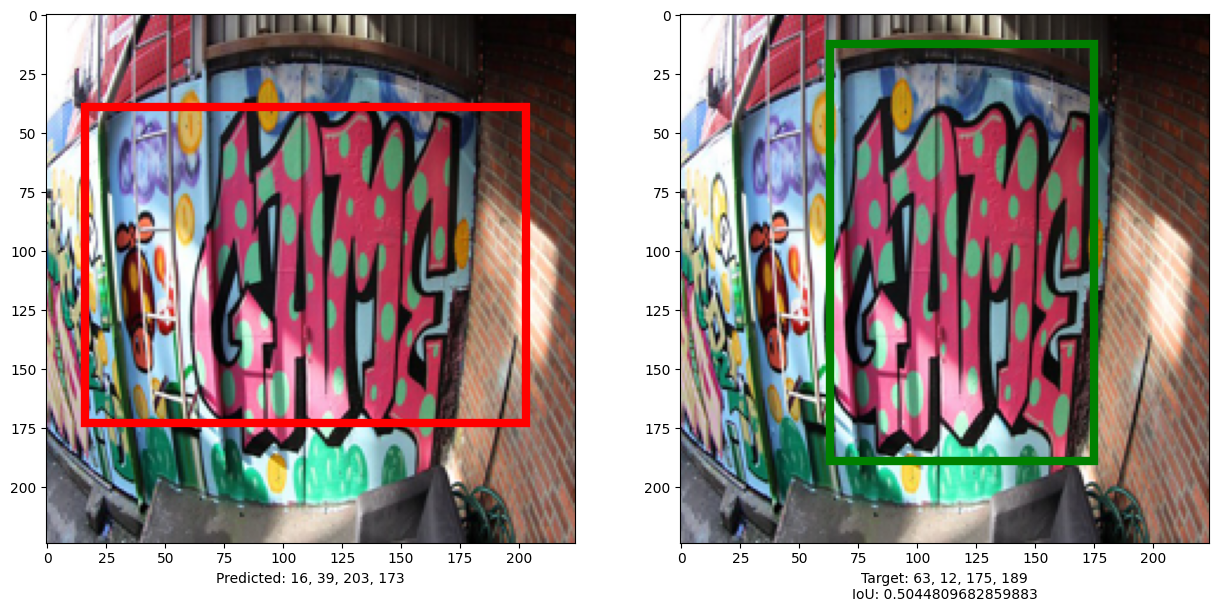

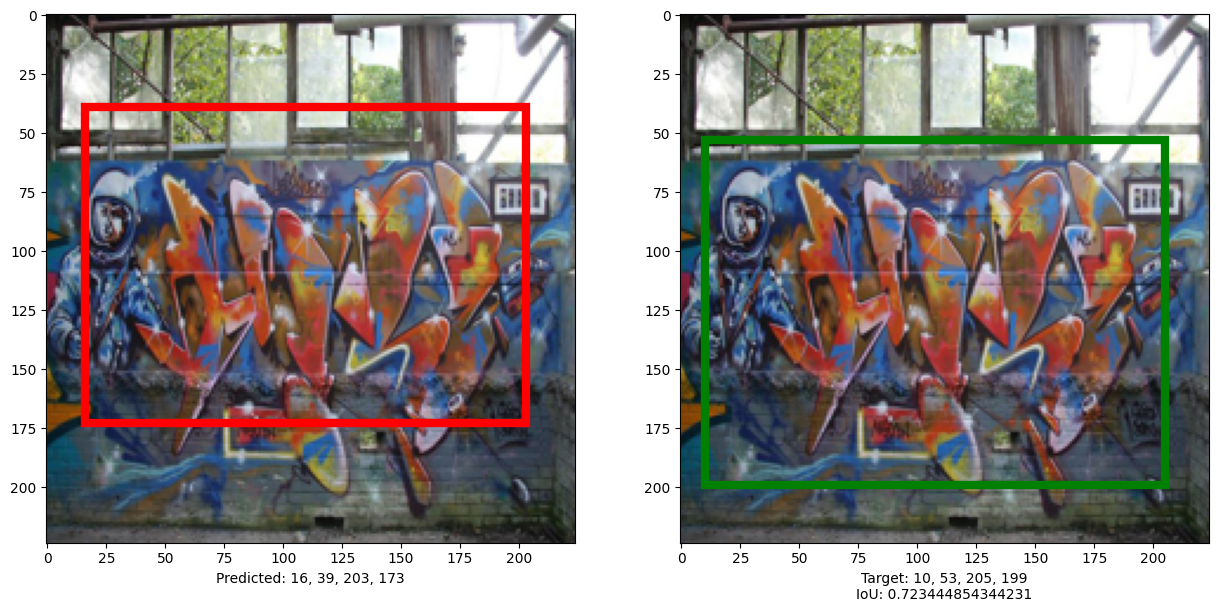

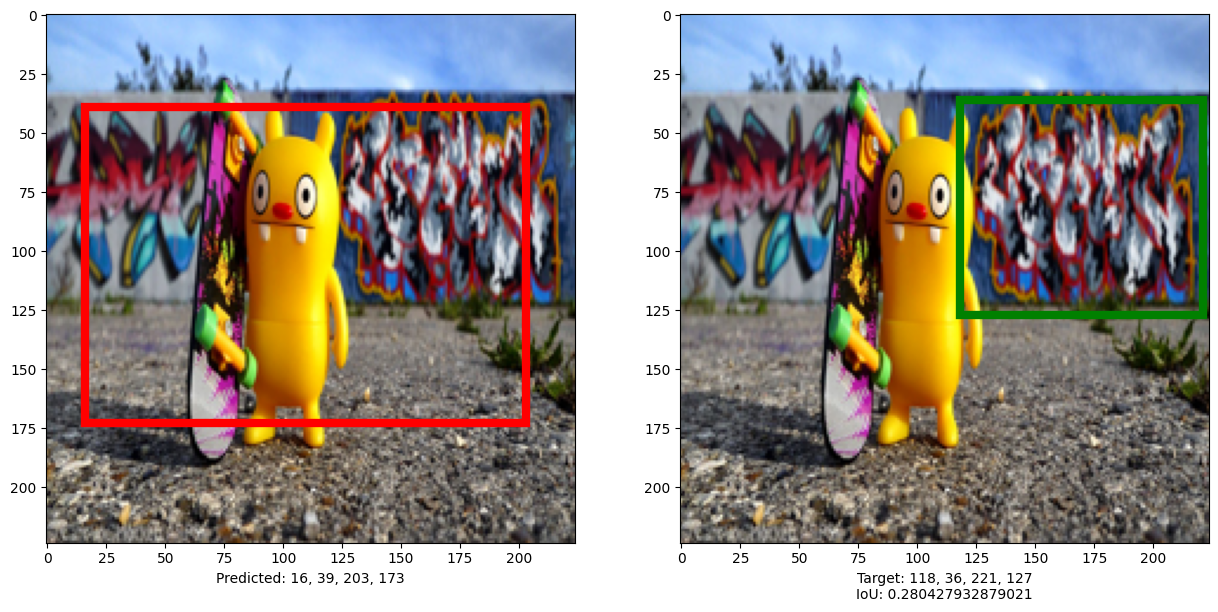

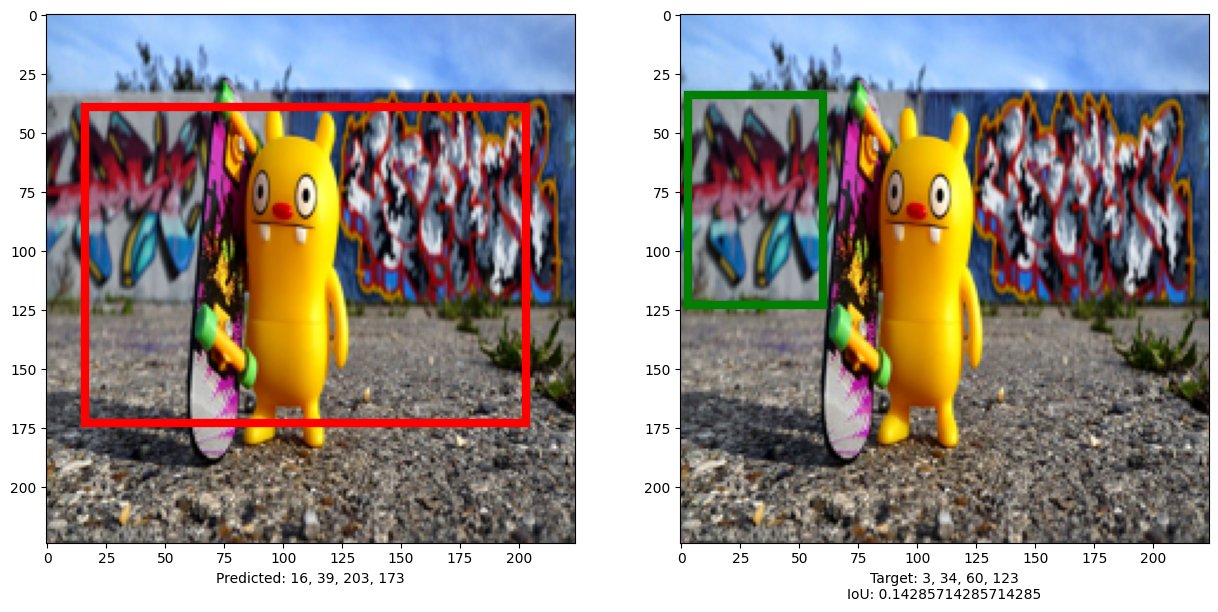

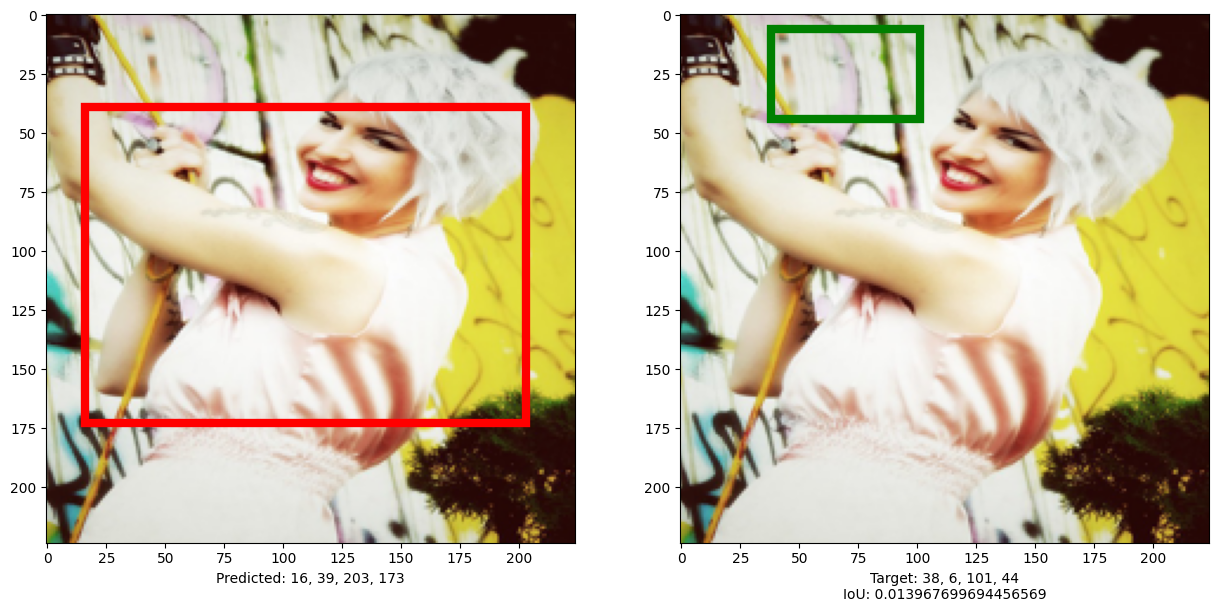

In [50]:
mean_iou = 0

# Compare results for 10 images in the test set
for i, input_image in enumerate(x_test[:10]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
    im = input_image

    # Display the image
    ax1.imshow(im.astype("uint8"))
    ax2.imshow(im.astype("uint8"))

    input_image = cv2.resize(
        input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = model.predict(input_image)[0]
    (h, w) = (im).shape[:2]

#     W_, H_ = x_train[0].shape[:2]

#     xmin, ymin = y_train[0][0]*W_, y_train[0][1]*H_
#     w_, h_ = (y_train[0][2] - y_train[0][0])*W_, (y_train[0][3] - y_train[0][1])*H_
    

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches_plt.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=6,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(y_test[i][0] * w), int(y_test[i][1] * h)

    bottom_right_x, bottom_right_y = int(y_test[i][2] * w), int(y_test[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches_plt.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="green",
        linewidth=6,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU: "
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    i = i + 1

print("mean_iou: " + str(mean_iou / len(x_test[:10])))
plt.show()

In [ ]:
# mean_iou = 0

# # Compare results for 10 images in the test set
# for i, input_image in enumerate(x_test[:20]):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))
#     im = input_image

#     # Display the image
#     ax1.imshow(im.astype("uint8"))
#     ax2.imshow(im.astype("uint8"))

#     input_image = cv2.resize(
#         input_image, (image_size, image_size), interpolation=cv2.INTER_AREA
#     )
#     input_image = np.expand_dims(input_image, axis=0)
#     preds_ = vit_object_detector.predict(input_image)
    
#     for j, preds in enumerate(preds_):

#         (h, w) = (im).shape[:2]

#         top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

#         bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

#         box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
#         # Create the bounding box
#         rect = patches.Rectangle(
#             (top_left_x, top_left_y),
#             bottom_right_x - top_left_x,
#             bottom_right_y - top_left_y,
#             facecolor="none",
#             edgecolor="red",
#             linewidth=1,
#         )
#         # Add the bounding box to the image
#         ax1.add_patch(rect)
#         ax1.set_xlabel(
#             "Predicted: "
#             + str(top_left_x)
#             + ", "
#             + str(top_left_y)
#             + ", "
#             + str(bottom_right_x)
#             + ", "
#             + str(bottom_right_y)
#         )

#         top_left_x, top_left_y = int(y_test[i][j][0] * w), int(y_test[i][j][1] * h)

#         bottom_right_x, bottom_right_y = int(y_test[i][j][2] * w), int(y_test[i][j][3] * h)

#         box_truth = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
#         print(box_predicted, box_truth)

#         mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
#         # Create the bounding box
#         rect = patches.Rectangle(
#             (top_left_x, top_left_y),
#             bottom_right_x - top_left_x,
#             bottom_right_y - top_left_y,
#             facecolor="none",
#             edgecolor="red",
#             linewidth=1,
#         )
#         # Add the bounding box to the image
#         ax2.add_patch(rect)
#         ax2.set_xlabel(
#             "Target: "
#             + str(top_left_x)
#             + ", "
#             + str(top_left_y)
#             + ", "
#             + str(bottom_right_x)
#             + ", "
#             + str(bottom_right_y)
#             + "\n"
#             + "IoU"
#             + str(bounding_box_intersection_over_union(box_predicted, box_truth))
#         )
        
# print("mean_iou: " + str(mean_iou / len(x_test[:20])))
# plt.show()